In [2]:
import os
from  urllib.request import urlopen
from urllib.parse import urlparse
import json
import nibabel as nib
import nilearn 

from extract_from_masks import *

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
atlas_location = '/home/jflournoy/code/arbitrary_nii_extraction/atlas'
update_atlas = True
atlas_json_fname = 'atlas_info.json'

In [4]:
def download_nii(url, dl_dir):
    parsed_url = urlparse(url)
    atlas_fname = os.path.split(parsed_url.path)[1]
    save_fname = os.path.join(dl_dir, atlas_fname)
    print('Downloading: ' + save_fname)
    response = urlopen(url)
    CHUNK = 16 * 1024
    with open(save_fname, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                break
            f.write(chunk)
        f.close()
    return(save_fname)

In [5]:
def update_atlases(which = None, atlas_dir = ''):
    url = "http://neurovault.org/api/atlases/"
    response = urlopen(url)
    data = response.read().decode("utf-8")
    atlases = json.loads(data)
    if (which == None):
        i = 0
        atlas_list = list()
        for result in atlases['results']:
            atlas_list.append(result['name'])
            print(i, ':', result['name'])
            i+=1
        raise ValueError('Please supply the index (as above) of the atlas you wish to update, or "all"')
    elif (which == 'all'):
        assert os.path.isdir(atlas_dir), 'Directory does not exist'
        for result in atlases['results']:
            local_fname = download_nii(url = result['file'], dl_dir = atlas_dir)
            
            result['local_file'] = local_fname
        json_fname = os.path.join(atlas_dir, atlas_json_fname)
        with open(json_fname, 'w') as f:
            json.dump(atlases, f)
            f.close()
        

In [6]:
# update_atlases(which = 'all', atlas_dir= atlas_location)

Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/JHU-ICBM-labels-2mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/JHU-ICBM-labels-1mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/JHU-ICBM-tracts-maxprob-thr25-2mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/JHU-ICBM-tracts-maxprob-thr25-1mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/MNI-maxprob-thr25-1mm.nii.gz
Downloading: /home/jflournoy/code/arbitrary_nii_extraction/atlas/MNI-maxprob

In [8]:
def get_atlas_fname(which = None, atlas_dir = ''):
    atlas_json_fullpath = os.path.join(atlas_dir, atlas_json_fname)
    assert os.path.isfile(atlas_json_fullpath), 'Atlas info doesn\'t exist. Run with --update_atlases?'
    with open(atlas_json_fullpath) as json_file:
        atlases = json.load(json_file)
        json_file.close()
    #Build list of atlases
    if (which == None):
        print('\n'.join([str(i) + ': ' + x['name'] for i, x in enumerate(atlases['results'])]))
        raise ValueError('Please supply the index (as above) of the atlas you wish to update, or "all"')
    atlas_fname = atlases['results'][which]['local_file']
    return(atlas_fname)

In [9]:
atlas_fname = get_atlas_fname(which = 3, atlas_dir = atlas_location)

In [10]:
masks = generate_masks(atlas_fname)

In [11]:
an_img_file = nib.load('/home/jflournoy/code/arbitrary_nii_extraction/test_file/self_other_z.nii')

In [13]:
from nilearn import plotting

/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


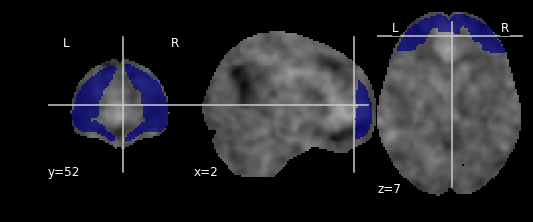

In [17]:
plotting.plot_roi(masks[1], bg_img = an_img_file)

In [26]:
masks[0].shape

(91, 109, 91)

/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "
/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


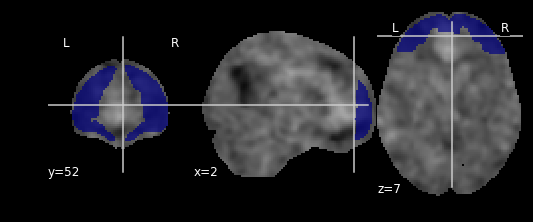

In [27]:
an_img_file_resamp=nilearn.image.resample_img(an_img_file, target_affine=masks[0].affine, target_shape=masks[0].shape)
plotting.plot_roi(masks[1], bg_img = an_img_file_resamp)

In [28]:
extract_from_masks(masks, an_img_file_resamp)

{'mask001': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'mask002': array([ 0.87582606,  1.08756628,  1.00674371, ..., -0.91344394,
        -1.10712012, -1.02350415]),
 'mask003': array([ 1.60471894,  1.57529506,  2.34720639, ...,  2.17699482,
         2.07401123,  1.96153006]),
 'mask004': array([ 0.73932159,  0.63689669,  0.22999047, ..., -1.836013  ,
        -1.56523879, -1.49968685]),
 'mask005': array([-1.0451065 , -0.74267368, -1.0698747 , ..., -2.64665957,
        -2.05501607, -2.2283935 ]),
 'mask006': array([ 0.78867178,  0.50895867,  0.11173626, ..., -1.0849591 ,
        -1.36132012, -1.05050708]),
 'mask007': array([-0.50933112,  1.42128524,  1.23971382, ...,  1.7542593 ,
         1.56728729,  1.45964803]),
 'mask008': array([-0.09814168, -0.4672438 , -1.09333932, ..., -0.44675882,
         0.10428718, -0.2947975 ]),
 'mask009': array([ 1.01288921,  1.15535294,  1.09296686, ...,  0.68289478,
         1.33059264,  1.52296524]),
 'mask010': array([  1.63712245e+00,   1.5717567